In [1]:
list.of.packages <- c("gdata","R.utils","rgdal","raster","rbioclim","stringr","stringi",
                      "proj4","data.table","FSA","plyr","wordcloud","KernSmooth","gdtools")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages) > 0) install.packages(new.packages)

lapply(list.of.packages, FUN = function(X) {
    do.call("require", list(X)) 
})

devtools::install_github("MoisesExpositoAlonso/rbioclim") # To download WorldClim
library(rbioclim) # To download WorldClim

Loading required package: gdata

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.



gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.


Attaching package: ‘gdata’


The following object is masked from ‘package:stats’:

    nobs


The following object is masked from ‘package:utils’:

    object.size


The following object is masked from ‘package:base’:

    startsWith


Loading required package: R.utils

Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.1 (2020-08-26 16:20:06 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.24.0 (2020-08-26 16:11:58 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:gdata’:

    ll, trim


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

  

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

Skipping install of 'rbioclim' from a github remote, the SHA1 (662b653b) has not changed since last install.
  Use `force = TRUE` to force installation



# Directory Setup and Data Download

As part of this exercise, we'll have to download climate and topographic information. The default directory to which files will be downloaded is the current working directory. If you'd like to specify a different folder, change "getwd()" to the filepath with frontslashes between quotes. (e.g. "I:/DataArc/")

In [2]:
path <- getwd()
setwd(path)
set.seed(1601720)
rasterOptions(maxmemory=1.1e9)

# Set up necessary directories
if (!dir.exists("WorldClim")) {dir.create("WorldClim")}
if (!dir.exists("DEM")) {dir.create("DEM")}

We'll also load the "Translator.R" file, that contains a custom function designed to convert an output JSON from the dataARC API to a parsable data.table or CSV. To use it, simply call "arc.dataconvert()" on a JSON or compressed JSON (.json.gz). If you'd like to export the converted table, simply add the argument "export = filepath" where filepath is the desired output file in .csv or .gz formats. Users who desire greater control over the data structure can modify the "Translator.R" file directly. 

In [3]:
source("Translator.R")

First we need to download the necessary rasters from the internet. This particular getData function from the rbioclim library first checks to see if the files already exist locally in the required directory and if not downloads them from the UC Davis repository. The provided resolutions are 2.5 arcminutes (around 1957 m at this latitude). They will be downsampled in a later step.

We start with the modern climate rasters. For time's sake  we are only downloading the pre-preprocessed bioclimatic variables for annual values although the user is free to change the download to "tmin", "tmax", or "prec" for monthly values of raw variables. Unfortunately, rbioclim does not provide a way to only extract a single variable, so this could take a while (~10 min depending on the computer for both sets).

importing dataset pres



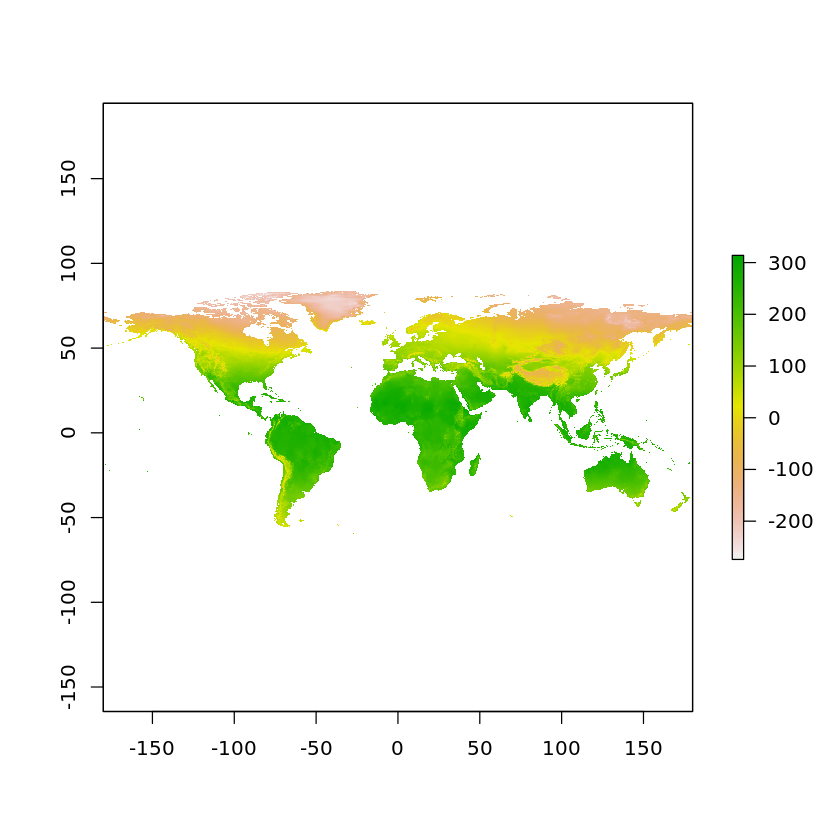

In [4]:
clim_p <- recursive.getData("pres",path="WorldClim",var="bio")
clim_p <- clim_p$pres[[1]]
plot(clim_p)

Notice that we're only selecting the first raster of the downloaded rasterBrick (the [[1]] subset). This means that the preprocessing will only be appled to the mean annual temperature raster. If the user would like to work with different types of climactic variables, they may change the subset according to the indices listed at: https://www.worldclim.org/data/bioclim.html

Next come the climate predictions. WorldClim provides predictions based on the CMIP6 model (CC prefix), which has predictions for 2050 and 2070 (final two digits of download code) at using four different climate scenarios (representative concentration pathways): 2.6, 4.5, 6.0, and 8.5 (first two digits of download code). 8.5 is generally taken as the worst-case scenario, but it is increasingly seen as unrepresentative of the most likely case given trends in CO2 emissions (https://www.nature.com/articles/d41586-020-00177-3). 

In this example we use 2.6--one of the best-case scenarios-- due to its proximity to the pathway aspired to by the Paris agreements, although the user is free to change both the year and pathway. For example, if we wanted to get the 8.5 pathway prediciton for 2070, we'd download CC8570

importing dataset CC2650



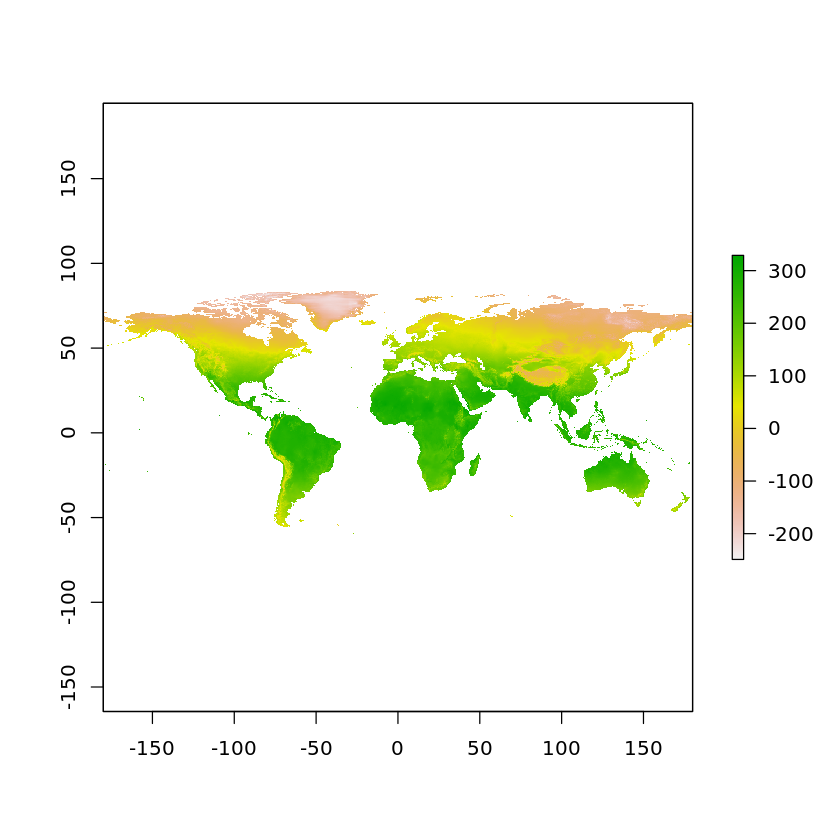

In [5]:
clim_f <- recursive.getData("CC2650",path="WorldClim",var="bio")
clim_f <- clim_f$CC2650[[1]]
plot(clim_f)

It's fine if you get a bunch (19) of Warnings. We'll reproject the data so it won't be an issue. 

Finally, the DEM is a little tricker. Iceland lies outside of the range covered  by the SRTM STS-99 mission and does not have publically-available national lidar coverage. The resource used in this demonstration is obtained from digitized topographic maps from declassified Russian intelligence sources. Data are provided at 15 arcsecond resolution (around 196 m at this latitude) but also available are 1", 3" and 5" from the website.

Due to computational limits at 2GB of memory for binders, we provide a pre-upsampled DEM. If this file is present in the main directory, the program will load that as the DEM. If not, it will check to see if the raw Russian data has been downloaded, and if so use that. If it hasn't, download and uncompress the necessary file.

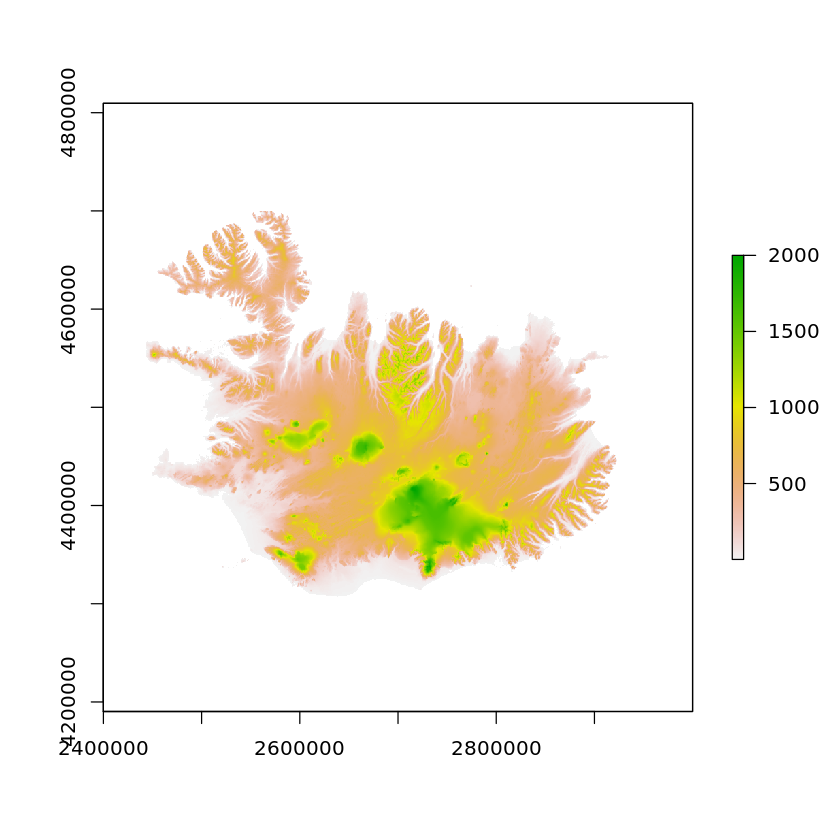

In [6]:
if (file.exists("Provided_DEM.tif")) {
    dem <- raster("Provided_DEM.tif")
} else {
    if (!file.exists("DEM/15-C.tif")) {
  download.file("http://www.viewfinderpanoramas.org/DEM/TIF15/15-C.zip", 
                destfile="DEM/isl_2010.zip")
  unzip("DEM/isl_2010.zip",exdir="DEM")
        }
dem <- raster("DEM/15-C.tif",sep="")
    }
plot(dem)

Finally, if you don't want to keep the originally-downloaded WorldClim and DEM files, you can delete them running the cell below. If you are running this script locally, considering using them again and are not short of storage space, we recommend keeping them to drastically reduce the processing time in the future.  

In [7]:
writeRaster(dem,"Iceland_DEM.tif",type="GTiff",overwrite=TRUE)
writeRaster(clim_f,"Iceland_Clim_Future.tif",type="GTiff",overwrite=TRUE)
writeRaster(clim_p,"Iceland_Clim_Present.tif",type="GTiff",overwrite=TRUE)

dem <- raster("Iceland_DEM.tif")
clim_f <- raster("Iceland_Clim_Future.tif")
clim_p <- raster("Iceland_Clim_Present.tif")

unlink("topo",recursive=TRUE)
unlink("WorldClim",recursive=TRUE)

# Raster Preprocessing

Now that we have downloaded the necessary files, we need to prepare them for analysis. For this, we need to address three issues:
1. The rasters are unprojected, with XY coorinates (planar variables), actually standing  for latitude/longitude (altitude and azimuth in spherical)
2. The rasters have different extents, all larger than the area of interest (Iceland),
3. The rasters are of different resolutions and have different origins. 

First, we'll define the projection we want and a bounding box that will cover the area of interest. Projections transform spherical/geodesic data (latitude and longitude relative to the WGS1984 spheroid) to planar data (XY coordinates on a flat surface). Since we're interested in performing operations related to area (such as densities) or distance, we need a conformal projection that minimizes both types of error. 

Iceland uses EPSG:9040---a Lambert Conformal Conic projection defined with the ISL2016 datum, but for most practical purposes WGS1984 will do. The _init_ file for proj4 included in this binder release does not have access to the complete list of EPSG codes, and as such the simple EPSG import has been commented out in this script. Users may employ that line if they are running the notebook or associated scripts locally. The projections, however, are identical. 

In [8]:
#proj <- CRS("+init=epsg:9040 +datum=WGS84")
proj <- CRS("+proj=lcc +lat_0=52 +lon_0=10 +lat_1=35 +lat_2=65 +x_0=4000000 +y_0=2800000
                    +datum=WGS84 +units=m +no_defs")

Next we need to crop the rasters to make them more manageble. Ideally, this should be no larger than our area of interest since the time needed toy process a raster increases according to the product of its length times its witdh---so large rasters get ver slow very quickly. The smaller the better. 

We'll define a blank raster that describes the area we're interested in in the target projection, then we'll transform its extent to the original projections of thedownloaded data, and finally we'll crop it.

In [9]:
ext <- raster()  # Dummy target extent raster
extent(ext) <- extent(2400000,3000000,4300000,4700000)
crs(ext) <- proj

ext_proj <- projectExtent(ext,dem) # The DEM
dem <- crop(dem,ext_proj)
dem[dem <= 0] <- NA # Since the ocean is reported as having Z = 0---we want it as NA

ext_proj <- projectExtent(ext,clim_f) # The WorldClim data. 
clim_f <- crop(clim_f,ext_proj)
clim_p <- crop(clim_p,ext_proj)

Now that the rasters are much smaller, we can reproject them to the target projection. We set the target resolution of the DEM at 200 m  since it's a friendlier number and bilinear interpolation is performed during the resampling, so we're drawing elevation estimates from an otherwise smooth model. We'll crop the model one more time  with an unprojected target extent to make sure that all of our  final analysis rasters are exactly the same size and have the same origin. If you're working off of the Jupyter Binder with the provided DEM, it'll skip this step.

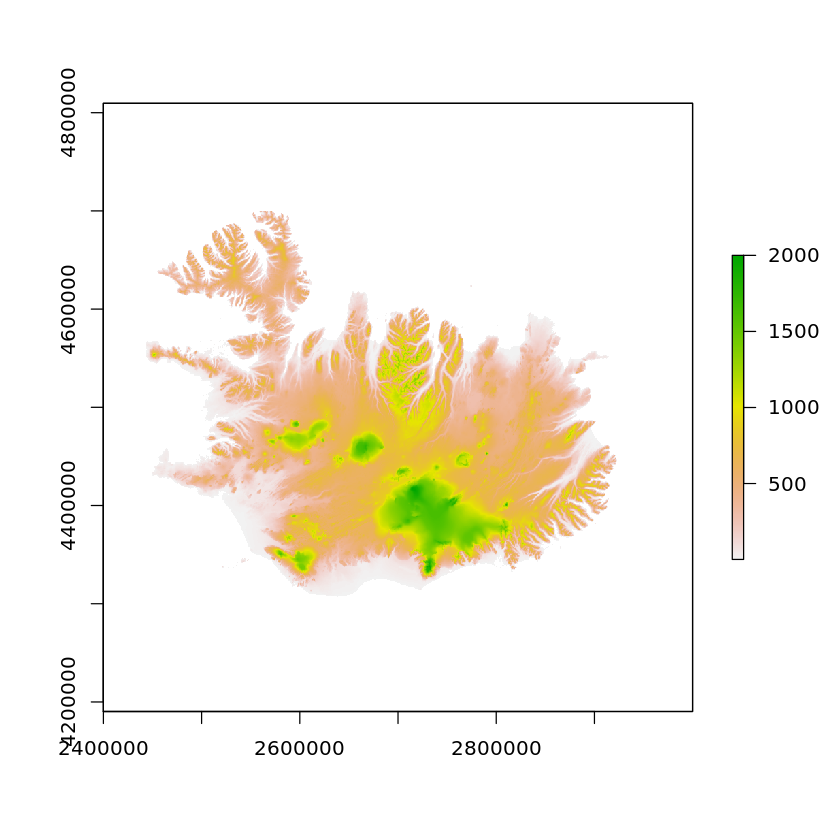

In [12]:
if (!file.exists("Provided_DEM.tif")) {
    dem <- projectRaster(dem,crs=crs(ext),res=200)
    dem <- crop(dem,ext)
}
plot(dem)

For the climate rasters, we want to downsample them so that the final products are of the same (smaller/finer) resolution as  the DEM. So we'll project them to the closest integer resolution in meters,  resample them to match the DEM's resolution and origin, and crop them with an unprojected extent. 

***NOTE THAT RESAMPLING DOES NOT GENERATE NEW INFORMATION*** 

You cannot get "more accurate" estimates for a particular location by downsampling them. Rather, you assume that the general trend at the coarser resolution is consistent over each step/pixel, and  estimate that tendency at a particular point. It cannot account for variances at smaller resolutions. 

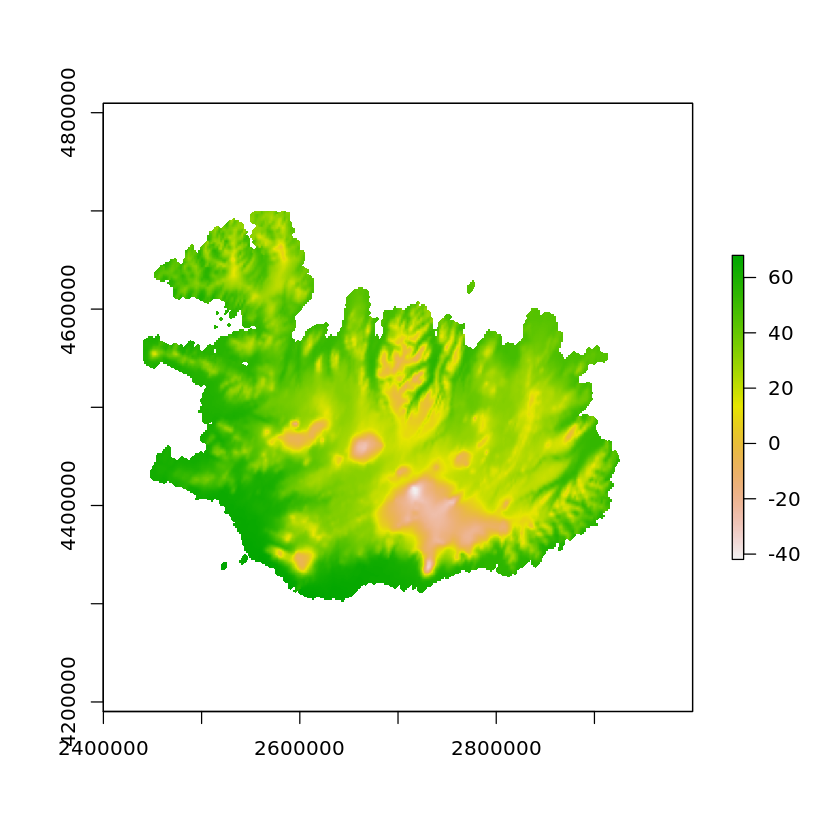

In [13]:
clim_f <- projectRaster(clim_f,crs=crs(ext),res=1957) #Project
clim_p <- projectRaster(clim_p,crs=crs(ext),res=1957)

clim_f <- resample(clim_f,dem) # Resample
clim_p <- resample(clim_p,dem)

clim_f <- crop(clim_f,ext) # and Crop
clim_p <- crop(clim_p,ext)

plot(clim_f)

Before we can finally move on to the analyses, we should (optionally) clean up our directories of files we won't use anymore and save the final data rasters so we don't have to re-generate them each time.

Export your rasters

In [14]:
writeRaster(dem,"Iceland_DEM.tif",type="GTiff",overwrite=TRUE)
writeRaster(clim_f,"Iceland_Clim_Future.tif",type="GTiff",overwrite=TRUE)
writeRaster(clim_p,"Iceland_Clim_Present.tif",type="GTiff",overwrite=TRUE)


Now if you've already generated these files and for some reason need to restart your session, you just need to import those rasters using the raster() function (use stack() for the climate raster if you used more than one subset bioclim variable).

# DataARC Preprocessing

Now we can finally import the DataARC output. You can use R's base class of data.frame, but it can be very slow for export operations, and while indexing large datasets such as DataARC. Instead, we'll use data.table for most of the operations.   We'll also "lapply" the *trimws* function to remove any whitespace to make things parsable. More on "lapply" later.  Starting from here, you need to make sure that the following files are in the current working directory:

1. OUT_WITH_CONCEPTS_COMBINATORS_RELATED.csv, containing the dataARC observations
2. CONCEPT_DATA_FRAME.csv, containing the concept hashes
3. DATASET_HASH_OUT.csv, containing the hashes for each original dataset

In [ ]:
arc <- arc.dataconvert("results.json.gz")
setnames(arc,names(arc),c("NUMBER","ID","Y","X","DATASET","CATEGORY","ENTRY","CONCEPT","COMBINATOR","RELATED","CONTEXT"))
arc[, names(arc) := lapply(.SD,trimws,which='left')]

tail(arc)


Attaching package: ‘jsonlite’


The following object is masked from ‘package:R.utils’:

    validate



Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:raster’:

    intersect, select, union


The following objects are masked from ‘package:gdata’:

    combine, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:raster’:

    extract


The following object is masked from ‘package:R.utils’:

    extract



Attaching package: ‘purrr’


The following object is masked from ‘package:jsonlite’:

    flatten


The following object is mask

The nice thing about data.tables is that we can manipulate the data in-place without having to generate a copy first. So, for example if there are entries in the XY columns that don't contain numbers, the columns are imported as if they were text. We'll use as.numeric to ensure that they're numbers

In [ ]:
arc[,c("X","Y") := lapply(.SD,as.numeric), .SDcols = c("X","Y")]

Data.tables are like data.frames, but far more powerful. Most of the action occurs in the indexing parameters, in the form [i,j,k,SD] where "i" is a number or a logical condition to filter rows, "j" how columns will be manipulated and returned,  "k" the features by which we can group, and SD indicating which columns to use for operations.

Notice that we used the ':=' symbol and didn't assign the output to a new variable or re-assign it to the original arc variable. The := symbol changes it in-place. .SD tells it to iteratively apply that function to all columns defined under .SDcols. We could have created *new* columns by simply changing the name of the strings in the first vector in the j slot.

DataARC also reports coordinates in unprojected decimal degrees according to the WGS1984 spheroid. We need to transform these values to the appropriate projection. 

The function we use to project raw coordinates in decimal degrees form expects radians in unprojected systems, so we first need to convert the XY to radians according to 180° = π rad

In [ ]:
arc[, `:=`(X = X * ..pi / 180, Y = Y * ..pi / 180)]

# Now we can convert to our projection system
arc[,`:=`(X = ptransform(.(X,Y),src.proj=CRS("+proj=longlat +datum=WGS84"),
                         dst.proj=proj)[[1]],
          Y = ptransform(.(X,Y),src.proj=CRS("+proj=longlat +datum=WGS84"),
                         dst.proj=proj)[[2]])]
arc[1:25,.(ID,X,Y)]

# Plotting dataARC Observations

Let's start off by making a plot of all the sites in the datasets. For this, we'll group by ID (since it belongs to different observations for each individual site) in the 3rd/k column, and take the mean of each  and X and Y column.  In theory, the X and Y should be the same for each entry with the same ID, so we could also use min() or max(), or list(unique()). We'll use the .SD feature so that we can use lapply to iteratively get the mean on each column.

In [ ]:
output <- arc[,lapply(.SD,mean), by=ID, .SDcols = c("X","Y")][,.(X,Y)]
output <- na.omit(output)

Now we convert this from a data.table to a SpatialPointsDataFrame object (a vector format, akin to a shapefile with point values), and plot onto the DEM using the raster package's plot function

In [ ]:
output <- SpatialPointsDataFrame(output[,.(X,Y)],output,proj4string=proj)
plot(dem)
plot(output,add=TRUE)

Alternatively, we can use the *mapview* library and view it on an interactive map. This will let us see what the entries are by clicking on each poins. If you're reading this as a Jupyter notebook, make sure that ["ipywidgets"](https://ipywidgets.readthedocs.io/en/latest/user_install.html), ["ipyleaflet"](https://ipyleaflet.readthedocs.io/en/latest/installation.html), and ["r-essentials"](https://anaconda.org/r/r-essentials)  have been installed with pip or conda. This example will not work in a binder, and has therefore been commented out. Otherwise, the R console or RStudio output windows can handle *mapview* without the need to go into the command line. 

In this example we plot with both in different cells in the event the user does not wish to install ipywidgets, ipyleaflet, and r-essential.

In [ ]:
#mapview::mapview(output)

The *mapview* plot is useful, but all of the concepts have been replaced by their hash. 
To tie a hash to a concept, we need to bring in the concepts dataframe

In [ ]:
concepts <- read.csv("CONCEPT_DATA_FRAME.csv",stringsAsFactors = FALSE)
concepts <- as.data.table(concepts)

Now let's plot all of the sites tied to the concept "butchery".
First we get the correct hash

In [ ]:
query <- concepts[concepts$NAME == "butchery",HASH] 

Next we filter DataArc rows according to those that have the butchery hash substring in the concept strings. The output file reports lists of concepts as strings of individual hashes separated by semicolons, which is why we use the str_detect function and not the %in% operator

In [ ]:
output <- arc[str_detect(CONCEPT,query), # Filters by hash, gets XY
              lapply(.SD,mean), by=.(ID,CONCEPT), .SDcols = c("X","Y")][,.(X,Y,CONCEPT)]
output <- na.omit(output) # Drops missing values
output <- SpatialPoints(output[,.(X,Y)],proj4string=proj) # Adds projection information
#mapview::mapview(output, map.types = "OpenTopoMap")

In [ ]:
plot(dem)
plot(output, add=TRUE)

How about something a little bit more difficult. 
For a complex example with multiple entries, let's search for concepts that may be related to farms or agriculture,.

In [ ]:
query <- c("agricultur| farm")

A bit of info about the specific query. 
- The "|" tells stringr that there are multiple candidate strings to look for, namely "agricult" and " farm"
- We searched for "agricultur" so that we can find anything containing "agriculture" and "agricultural"
- We added a space before "farm" (i.e. " farm") to explicitly reject entries  that are ***only*** farm. This will return concepts where farm is not the first word. We do this to limit the number of sites that are displayed, otherwise the display will be saturated. 

In [ ]:
hash <- concepts[str_detect(concepts$NAME, query)] # Finds the right hashes
hashes <- paste(hash$HASH,collapse="|") # Puts them in a format readable by stringr
output <- arc[str_detect(CONCEPT,hashes), # Filters by hash, gets XY and concept
              lapply(.SD,mean), by=.(ID,CONCEPT), .SDcols = c("X","Y")][,.(X,Y,CONCEPT)]

Unlike the butchery example, we know we have different concepts that may or may not be found in the same locations. So we need to group not only by XY but also by *individual* concepts to properly plot the data. This means that we need to convert the concepts string to a list using tstrsplit, and then bust each row so that each element in the concept list  gets its own row using unlist. We now can then group by XY. 

In [ ]:
output <- output[, .(CONCEPT = unlist(tstrsplit(CONCEPT,":"))), by=c("X","Y")] # Convert to List
output <- output[CONCEPT %in% hash$HASH,.(CONCEPT),by=c("X","Y")] # Filter unwanted concepts

Plotting with the base/raster "plot" function requires that we give each concept a dummy index so that we can plot it with different symbols. For mapview we just passs the "CONCEPT" column to zcols.

In [ ]:
output[, `:=`(DUMMY = match(CONCEPT,..hash$HASH))]
output <- na.omit(output) # Drops missing values
output <- SpatialPointsDataFrame(output[,.(X,Y)],output[,.(CONCEPT,DUMMY)],
                                 proj4string=proj) # Adds projection information
output$CONCEPT <- hash$NAME[match(output$CONCEPT, hash$HASH)]

# with MapView
#mapview::mapview(output, zcols = "CONCEPT", map.types = "OpenTopoMap") # Plot the result

# with plot
# Plot the DEM again to clear the display, then plot the points
plot(dem)
plot(output, pch=(1:length(output))[output@data$DUMMY],
     col=(1:length(output))[output@data$DUMMY],
     add= TRUE)

# Add a legend
legend("topright",hash$NAME,
       pch=(1:length(output)),
       col=(1:length(output)))

# Exploring Climate Risks to sites with dataARC

Let's visualize how different concepts relate to different types of environments (albeit modern, in this example). Recall that first of the bioclimatic variables provided by WorldClim contains average annual temperature. Let's plot it again

In [ ]:
plot(clim_p)

Take a close look at the scale range. Those aren't degrees. They're decidegrees (i.e. 1/10 of one degree Celcius). Let's fix that

In [ ]:
clim_p <- clim_p / 10

To get the average annual temperature of the farm and agriculture concepts, we use the "extract" function. 

In [ ]:
output$Temp <- extract(clim_p,output)

And we can create histograms using the "hist" function from the FSA library

In [ ]:
hist(output$Temp~output$CONCEPT, 
     same.ylim=FALSE, w=2.5,
     xlab = "Temperature (degrees Celcius)",
     ylab = "Frequency")

The general perspective agrees with what we saw in the map. Sites labeled as church farms tend to be located in two distinct clusters on the island, and thus congregate around two temperature values. There're only a handful of tenant farms, so that histogram is heavily biased. Independent farms are biased towards the valleys of the north coast, also reflected in the histogram.

One ever-growing danger to the preservation of sites is climate change, particularly with increasing temperatures. This largely affects the preservation of organic remains. Let's first create a map of how much the average annual temperature is expected to change by 2050

Let's create a map of how much the average annual temperature is expected to change by 2050

In [ ]:
clim_f <- clim_f / 10 # Don't forget to convert the predicted temperatures to degrees!
change <- clim_f - clim_p
plot(change)

As we can see, the climate change models aren't entirely finely-grained. They can really only predict broad trends in expected change. Regardless, let's get the temperature data for ALL sites, and identify the ones at greatest risk (we'll define it as more than 2 degrees Celsius of change)

In [ ]:
output <- arc[,lapply(.SD,mean), by=.(ID,CONCEPT), .SDcols = c("X","Y")][,.(X,Y,CONCEPT)] # Combine Sites
output <- na.omit(output) # Exclude null values
output <- SpatialPointsDataFrame(output[,.(X,Y)],output[,.(X,Y,CONCEPT)],proj4string=proj) # Convert to spatial
output$TempChange <- extract(change,output) # Extract the temperature change
warming_sites <- output[complete.cases(output@data$TempChange),] # Keep only sites with real values
warming_sites <- warming_sites[warming_sites$TempChange >= 2.0,] # Only keep sites warming by more than 2 deg

We can also estimate sites at risk due to sea level rise (defined here as at an elevation at or below one meter above sea level)

In [ ]:
output$Elevation <- extract(dem,output) # Extract elevation
flooding_sites <- output[complete.cases(output@data$Elevation),] # Keep only sites with real values
flooding_sites <- flooding_sites[flooding_sites$Elevation <= 1,] # Only keep sites below 1 meter above sea level

Finally, we can bring in the sites that the DataARC team has already, identified as at-risk using the *Environmental Threats to Icelandic Archaeological Sites* dataset

In [ ]:
datasets <- read.csv("DATASET_HASH_OUT.csv",
                     stringsAsFactors = F,
                     encoding='UTF-8') # Get dataset hash list
datasets <- as.data.table(datasets)
datasets[, names(datasets) := lapply(.SD,trimws,which='left')]
query <- "Threat" # Set our keyword
threat <- datasets[str_detect(NAME,query),HASH] # Pull out the correct hash
threat <- toupper(threat) # Since arc hashes are in all caps
threatened_sites <- arc[DATASET == threat, 
                        lapply(.SD,mean), by=.(ID,CONCEPT),
                        .SDcols = c("X","Y")][,.(X,Y,CONCEPT)]
threatened_sites <- SpatialPointsDataFrame(threatened_sites[,.(X,Y)],
                                          threatened_sites,
                                          proj4string = proj)

To visualize all of the at-risk sites together, we need to combine them into the same data.table object and convert it to a SpatialPointsDataFrame to plot with *mapview*. Alternatively, we can just plot with base each original file setting different display settings

In [ ]:
cols = c("X","Y","CONCEPT","TYPE") # Define the columns we'll later keep
warming_sites$TYPE <- "Temperature" # Assign risk types
flooding_sites$TYPE <- "Flooding"
threatened_sites$TYPE <- "DataARC"
threatened <- data.table(rbind(warming_sites@data[,(cols)], # Combine risk types
                               flooding_sites@data[,(cols)],
                               threatened_sites@data[,(cols)]))
threatened[, c("X","Y") := lapply(.SD,as.numeric),.SDcols = c("X","Y")]
threatened_points <- SpatialPointsDataFrame(threatened[,.(X,Y)],threatened, proj4string = proj) # Convert to Spatial
#mapview::mapview(threatened_points,zcol="TYPE") # Plot

plot(dem)
plot(warming_sites, pch=1, col=1,add=T)
plot(flooding_sites, pch=2, col=2,add=T)
plot(threatened_sites, pch=3, col=3,add=T)
legend("topright", c("Temperature Change","Flooding","DataARC 'At-Risk'"),
       pch=1:3,col=1:3)

To explore this data further, let's get a sense of what concepts are present throughout the threatened sites. We need to separate the concept strings into into rows as above, and swap out the hashes for concepts

In [ ]:
threatened <- threatened[, .(CONCEPT = unlist(tstrsplit(CONCEPT,":"))), 
                         by=c("X","Y","TYPE")]
threatened[, CONCEPT := ..concepts$NAME[match(CONCEPT,..concepts$HASH)]]
threatened <- na.omit(threatened)

*Quick aside: Why not just unpack all of the concepts in the beginning when we import DataArc for the first time? String operations can be very time-taking, even with data.table. When we consider that we'd have over 1,000,000 observations, some linked to as many as ten concepts, that's millions of potential operations. It's faster to winnow down the list to the sites we're interested in, and THEN split the columns.*

Finally, we'll count the number of observations for each concept, and generate a wordcloud.

In [ ]:
counts <- count(threatened$CONCEPT)
wordcloud(counts$x,counts$freq,random.order = FALSE, colors=brewer.pal(8, "Dark2"))